# AlexNet 模型复现

模型结构图：

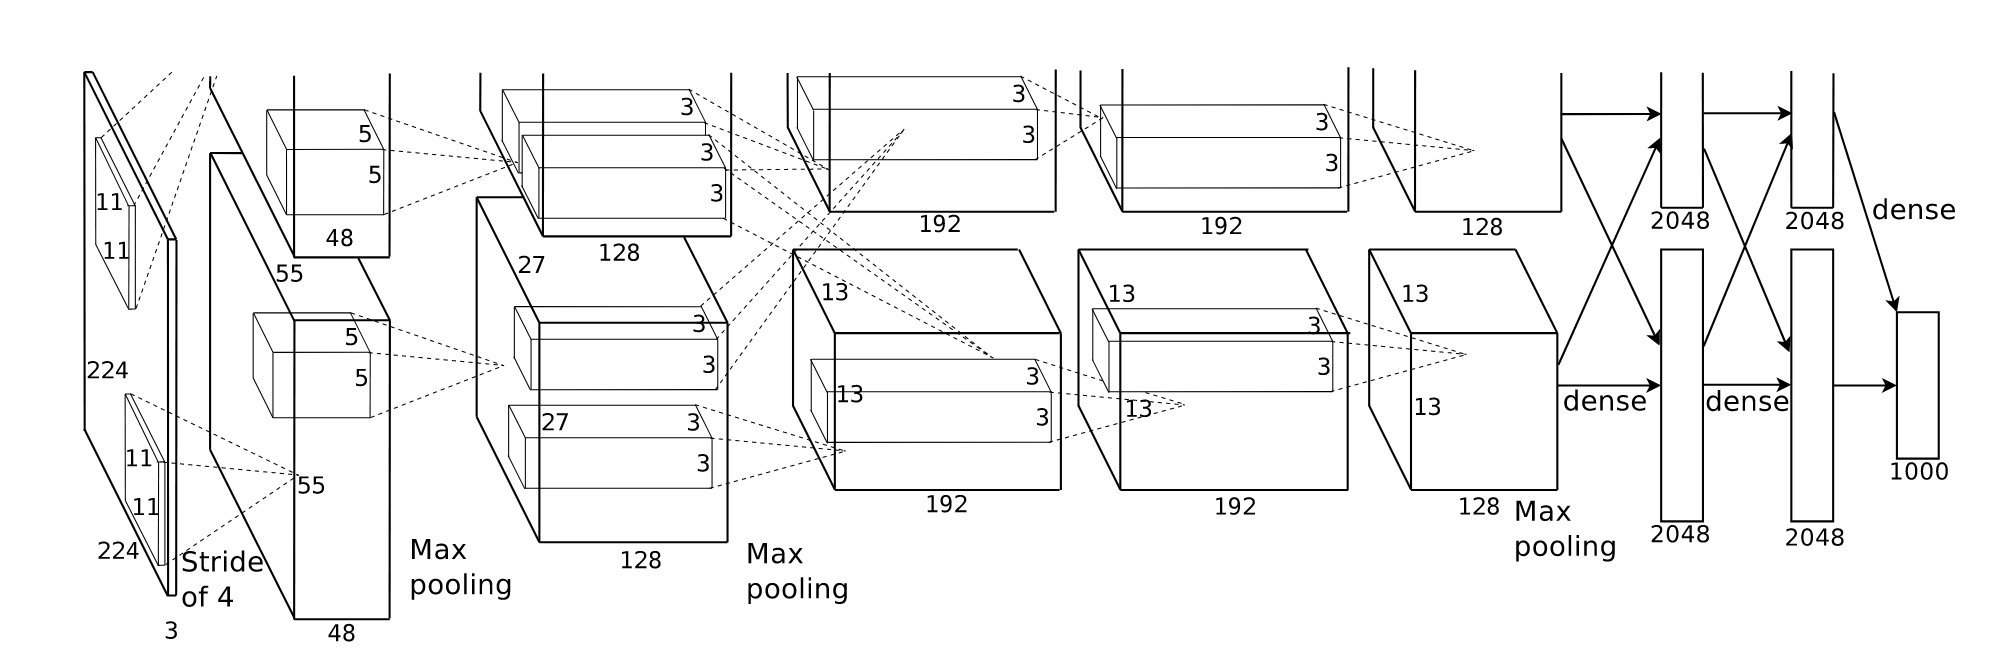

## 导入依赖库

In [7]:
import torch
from torch import nn
from torch import optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import cv2

from tqdm import tqdm
import wandb

import random
import os

def set_seed(seed):
    # 设置Python内置的随机数生成器的种子
    random.seed(seed)
    # 设置NumPy随机数生成器的种子
    np.random.seed(seed)
    # 设置PyTorch随机数生成器的种子
    torch.manual_seed(seed)
    # 如果使用多个GPU，设置所有GPU的种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    # 设置torch.backends.cudnn的随机性
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 调用set_seed函数并传入一个具体的种子值，比如42
set_seed(42)

device = "cuda:0" if torch.cuda.is_available() else "cpu"

device

'cuda:0'

In [8]:
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

data_root_path = r"/root/autodl-tmp/database/tiny-imagenet-200"
train_data_path = os.path.join(data_root_path, "train")
val_data_path = os.path.join(data_root_path, "val")

train_dataset = torchvision.datasets.ImageFolder(train_data_path, transform=transform)

val_dataset = torchvision.datasets.ImageFolder(val_data_path, transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, num_workers=4)


### 输入图片尺寸变化公式

假设：
- 输入图片的高度为 $ H $
- 输入图片的宽度为 $ W $
- 卷积核的高度为 $ K_h $
- 卷积核的宽度为 $ K_w $
- 步幅（stride）为 $ S $
- 填充（padding）为 $ P $（通常是对高度和宽度进行对称填充）

卷积操作后输出图片的高度 $ H_{out} $ 和宽度 $ W_{out} $ 的计算公式如下：

$ H_{out} = \left\lfloor \frac{H - K_h + 2P}{S} \right\rfloor + 1 $

$ W_{out} = \left\lfloor \frac{W - K_w + 2P}{S} \right\rfloor + 1 $

### Same 卷积

在卷积神经网络中，"same" 卷积指的是通过适当的填充使输出的尺寸与输入的尺寸相同。要实现 "same" 卷积，我们需要根据卷积核的大小 $ \text{kernel size} $ 和步幅 $ \text{stride} $ 来计算填充 $ \text{padding} $。

对于 "same" 卷积，填充的计算公式为：
$ \text{padding} = \left\lfloor \frac{\text{kernel size} - 1}{2} \right\rfloor $



In [9]:
class AlexNet(torch.nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=6*6*256, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=200),
            nn.Softmax(dim=1)
        )
        self.initilize()
    
    def initilize(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        features = self.features(x)
        result = self.classifier(torch.flatten(features, start_dim=1, end_dim=-1))
        return result

In [10]:
def train(model, lr, momentum, batch_size, num_epochs):
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    criterion = nn.CrossEntropyLoss()

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    for epoch in range(num_epochs):
        total_loss = 0
        total_correct = 0
        pbar = tqdm(train_loader)
        for image, label in pbar:
            image, label = image.to(device), label.to(device)
            pred = model(image)
            loss = criterion(pred, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss * image.shape[0]
            pred_label = torch.argmax(pred, dim=1)
            correct = (pred_label == label).sum()
            total_correct += correct

            pbar.set_description(f"lr:{lr}, momentum:{momentum}, batch_size:{batch_size}, num_epochs:{num_epochs} - Epoch:Train [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Acc: {correct/image.shape[0]:.4f}")
        pbar.set_description(f"lr:{lr}, momentum:{momentum}, batch_size:{batch_size}, num_epochs:{num_epochs} - Epoch:Train [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_dataset):.4f}, Acc: {total_correct/len(train_dataset):.4f}")

In [11]:
def val(model, lr, momentum, batch_size, num_epochs):
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        pbar = tqdm(val_loader)
        for image, label in pbar:
            image, label = image.to(device), label.to(device)
            pred = model(image)
            loss = criterion(pred, label)

            total_loss += loss * image.shape[0]
            pred_label = torch.argmax(pred, dim=1)
            correct = (pred_label == label).sum()
            total_correct += correct

            pbar.set_description(f"lr:{lr}, momentum:{momentum}, batch_size:{batch_size}, num_epochs:{num_epochs}\nEpoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Acc: {correct/image.shape[0]:.4f}")

In [12]:
model = AlexNet().to(device)
train(model, 1e-4, 0.9, 32, 100)

lr:0.0001, momentum:0.9, batch_size:32, num_epochs:100 - Epoch:Train [1/100], Loss: 5.2985, Acc: 0.0000:  28%|██▊       | 877/3125 [00:40<01:43, 21.71it/s]


KeyboardInterrupt: 